# Imports

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd o que o erro de 4
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/datasets/dados_violencia_mulheres_ses_modelado.parquet')

# One-Hot Encoding

Aqui, será aplicado One-Hot Encoding nas variáveis categóricas restantes:
- local_ocorrencia
- mesorregiao

In [ ]:
# captura as colunas categóricas
categorical_columns = df.select_dtypes(include='object').columns.tolist()

encoder = OneHotEncoder(sparse_output=False)
encoded_cols = encoder.fit_transform(df[categorical_columns])

encoded_df = pd.DataFrame(encoded_cols, columns=encoder.get_feature_names_out(categorical_columns))
encoded_df = encoded_df.rename(columns={
    'local_ocorrencia_Instituição pública/privada': "local_instit_publica_privada",
    'local_ocorrencia_Lazer/Consumo': "local_lazer_consumo",
    'local_ocorrencia_Outros': "local_outros",
    'local_ocorrencia_Residência': "local_residencia",
    'local_ocorrencia_Via pública': "local_via_publica",
    'mesorregiao_Campo das Vertentes': "regiao_campo_das_vertentes",
    'mesorregiao_Central Mineira': "regiao_central_mineira",
    'mesorregiao_Jequitinhonha': "regiao_jequitinhonha",
    'mesorregiao_Metropolitana de Belo Horizonte': "regiao_metrop_belo_horizonte",
    'mesorregiao_Noroeste de Minas': "regiao_noroeste_de_minas",
    'mesorregiao_Norte de Minas': "regiao_norte_de_minas",
    'mesorregiao_Oeste de Minas': "regiao_oeste_de_minas",
    'mesorregiao_Sul/Sudoeste de Minas': "regiao_sul_sudoeste_de_minas",
    'mesorregiao_Triângulo Mineiro/Alto Paranaíba': "regiao_triangulo_mineiro_alto_paranaiba",
    'mesorregiao_Vale do Mucuri': "regiao_vale_do_mucuri",
    'mesorregiao_Vale do Rio Doce': "regiao_vale_do_rio_doce",
    'mesorregiao_Zona da Mata': "regiao_zona_da_mata"
})
print("Shape: ", encoded_df.shape)

Shape:  (448331, 17)


#### Concatenating dataframes

In [ ]:
df_concat = pd.concat([df, encoded_df], axis=1)

# removendo variáveis que não vão agregar
df_concat.drop(columns=["local_ocorrencia", "mes_notificacao", "dia_notificacao", "dia_semana", "primeiro_semes", "segundo_semes", "mesorregiao"], inplace=True)

# convertendo todas as variáveis para inteiro
df_concat = df_concat.astype('int16')
display(df_concat.head())
print("Número de colunas: ", df_concat.shape[1])

,viol_fisica,viol_sexual,viol_psicologica,viol_autoprovocada,dia_util,fim_semana,primeiro_trim,segundo_trim,terceiro_trim,quarto_trim,vitima_cor_parda,vitima_cor_branca,vitima_cor_preta,vitima_cor_amarela,vitima_cor_indigena,vitima_lgbt,vitima_cis_hetero,autor_sex_masculino,autor_sex_feminino,violencia_repetitiva,violencia_unica,unico_agressor,multiplos_agressores,vitima_crianca,vitima_jovem,vitima_adulto,vitima_meia_idade,vitima_idoso,vitima_senior,local_instit_publica_privada,local_lazer_consumo,local_outros,local_residencia,local_via_publica,regiao_campo_das_vertentes,regiao_central_mineira,regiao_jequitinhonha,regiao_metrop_belo_horizonte,regiao_noroeste_de_minas,regiao_norte_de_minas,regiao_oeste_de_minas,regiao_sul_sudoeste_de_minas,regiao_triangulo_mineiro_alto_paranaiba,regiao_vale_do_mucuri,regiao_vale_do_rio_doce,regiao_zona_da_mata
0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0


Número de colunas:  46


## Visualizando a correlação das variáveis

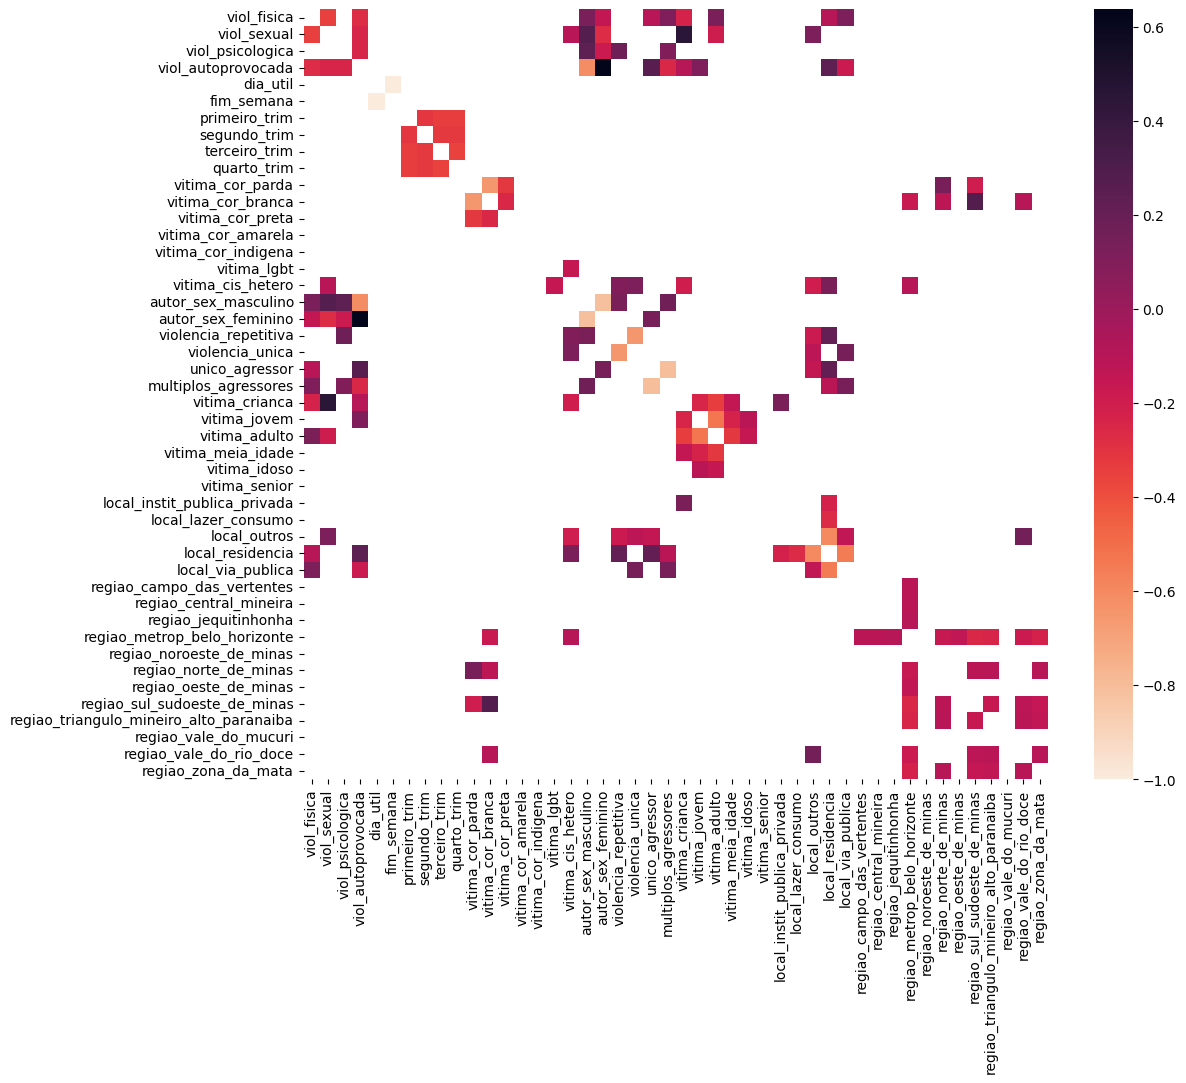

In [ ]:
corr = df_concat.corr(method="pearson")
corr_filter = corr[abs(corr) >= 0.1]
np.fill_diagonal(corr_filter.values, np.nan)

plt.figure(figsize=(12,10))
sns.heatmap(corr_filter,
            cmap=sns.color_palette("rocket_r", as_cmap=True))
plt.show()

# Principal Component Analysis (PCA)

- **Componente:** características ou colunas originais do conjunto de dados. Cada linha representa o componente principal que foi formado a partir de uma combinação das características originais
- **Variação explicada:** mostra o quanto da variação total dos dados cada componente captura. Esses valores indicam quanta informação cada componente está capturando. O primeiro componente(principal) captura a maioria da variação, e cada componenete subsequente captura progressivamente menos
- **Variação acumulada:** mostra a porcentagem da variação total capturada quando os componentes principais até aquele ponto são somados. Se chegar a 100%, seus componentes estão capturando toda a variação dos dados

In [ ]:
# cópia do dataframe para utilizar nesta etapa
df_pca = df_concat.copy()

n_components = 41
pca = PCA(n_components)
pca.fit_transform(df_pca)

explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

pca_data = {
    "Componente": [f"{i}" for i in range(1, n_components + 1)],
    "Variação Explicada": explained_variance,
    "Variação Acumulada": cumulative_variance
}

pca_results_df = pd.DataFrame(pca_data).round(4)
pca_results_df

,Componente,Variação Explicada,Variação Acumulada
0,1,0.1028,0.1028
1,2,0.0775,0.1804
2,3,0.0730,0.2534
3,4,0.0677,0.3211
4,5,0.0575,0.3786
5,6,0.0541,0.4327
6,7,0.0490,0.4818
7,8,0.0428,0.5246
8,9,0.0410,0.5656
9,10,0.0397,0.6053


#### Variação Explicada Acumulada pelo PCA

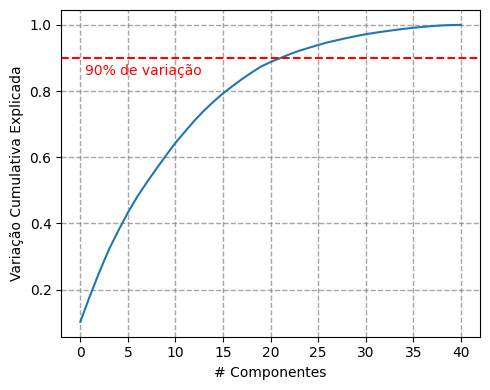

In [ ]:
plt.figure(figsize=(5, 4))
plt.plot(cumulative_variance)
plt.xlabel('# Componentes')
plt.ylabel('Variação Cumulativa Explicada')
plt.axhline(y=0.90, color='r', linestyle='--')
plt.text(0.5, 0.85, '90% de variação', color = 'red')
plt.grid(True, linestyle="--", color="grey", linewidth=1, alpha=0.7)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/datasets/imgs/variacao_explicada_acumulada_pelo_PCA.png")
plt.show()

#### Variação explicada por cada componente

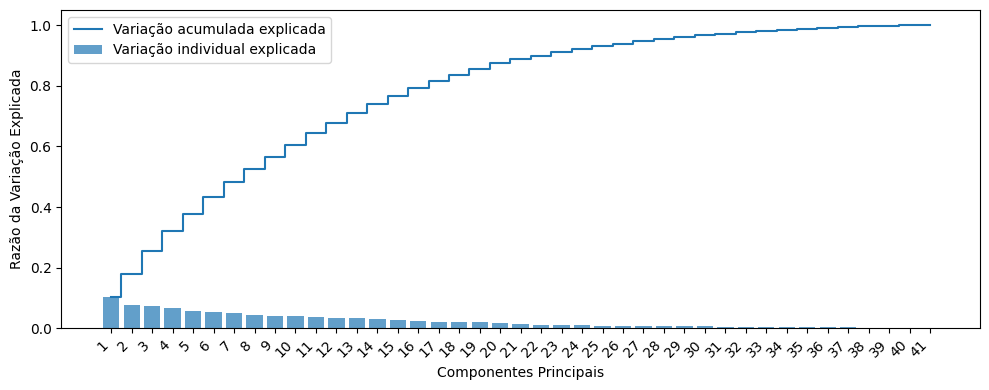

In [ ]:
plt.figure(figsize=(10, 4))
plt.bar(range(1, n_components+1), explained_variance, alpha=0.7, align='center', label='Variação individual explicada')
plt.step(range(1, n_components+1), cumulative_variance, where='mid', label='Variação acumulada explicada')
plt.ylabel('Razão da Variação Explicada')
plt.xlabel('Componentes Principais')
plt.legend(loc='best')
plt.xticks(range(1, n_components+1), rotation=45, ha="right")
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/datasets/imgs/variacao_explicada_por_cada_componente.png")
plt.show()

#### Escolha da quantidade de componentes

A escolha foi feita priorizando reduzir o máximo de componentes e manter uma boa variação explicada da base

In [ ]:
n_final_components = 20
final_pca = PCA(n_final_components, random_state=42)
pca_data = final_pca.fit_transform(df_pca)


#### Elbow Method

O Elbow Method auxilia na descoberta do melhor valor de **k** através da soma dos quadrados intra-cluster, ou inércia (WCSS).

- **WCSS:**  é uma métrica que consegue dizer o quão compacto são os clusters encontrados (por isso ele precisa de rodar o K-Means).

**Como funciona?**
Para cada cluster o algoritmo encontra o respectivo **centróide**, mede a distância de **cada ponto** que está nesse cluster até esse centróidem, eleva essa distância ao quadrado e soma tudo.

*O WCSS sempre diminui conforme o número de clusters é aumentado!*

Contudo, isso não quer dizer que vamos buscar apenas minimizar essa métrica, pois chega um momento em que adicionar mais clusters apenas divide grupos que já estavam bem coesos, diminuindo a WCSS muito pouco. **Não vale o trade-off!**

In [ ]:
wcss = []
max_clusters = 15
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i,
        init='k-means++',
        n_init=20,
        random_state=42)

    kmeans.fit(pca_data)
    wcss.append(kmeans.inertia_)

# Criando um DataFrame com a quantidade de clusters e WCSS
result_wcss = pd.DataFrame({'Número de clusters': range(1, max_clusters + 1),
                            'WCSS': wcss})

result_wcss_df = result_wcss.round(3)
result_wcss_df

,Número de clusters,WCSS
0,1,2406063.992
1,2,2161396.447
2,3,2025667.468
3,4,1947828.335
4,5,1877667.184
5,6,1821860.651
6,7,1767895.022
7,8,1736735.547
8,9,1699083.843
9,10,1662693.221


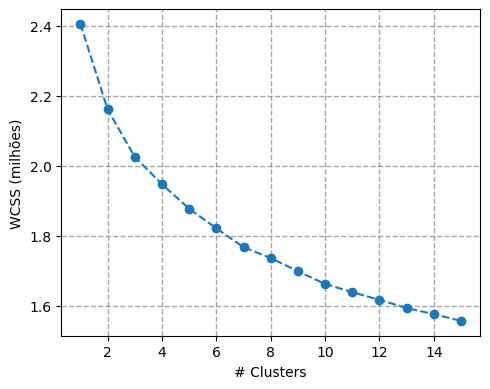

In [ ]:
wcss_M = [x / 1000000 for x in wcss]

plt.figure(figsize=(5,4))
plt.plot(range(1, max_clusters + 1), wcss_M, marker='o', linestyle='--')
plt.xlabel('# Clusters')
plt.ylabel('WCSS (milhões)')
plt.grid(True, linestyle="--", color="grey", linewidth=1, alpha=0.7)
plt.tight_layout()
plt.savefig("/content/drive/MyDrive/datasets/imgs/elbow_method.png")
plt.show()

# Treinamento do K-Means

In [ ]:
train_data = pca_data.copy()
clustered_df = df_pca.copy()

In [ ]:
n_clusters = [3, 4, 5]

clusters_dict = {}
models_dict = {}

for k in n_clusters:
  kmeans = KMeans(
      n_clusters=k,
      init='k-means++',
      n_init=20, # number of times the k-means algorithm will run with different centroid seeds
      max_iter=1000,
      verbose=0,
      random_state=42)

  clusters = kmeans.fit_predict(train_data)
  # salva o modelo
  models_dict[k] = kmeans
  # salva os clusters
  clusters_dict[k] = clusters

  cluster_counts = pd.Series(clusters).value_counts()
  print(f"Distribuição de clusters para k = {k}:\n{cluster_counts}")
  print()

  # atribui os cluster ao dataframe
  clustered_df[f"cluster_k_{k}"] = clusters

Distribuição de clusters para k = 3:
2    183591
1    145934
0    118806
Name: count, dtype: int64

Distribuição de clusters para k = 4:
2    135710
1    118766
3    117504
0     76351
Name: count, dtype: int64

Distribuição de clusters para k = 5:
4    122132
1    100050
3     99579
2     66983
0     59587
Name: count, dtype: int64



In [ ]:
clustered_df[['cluster_k_3', 'cluster_k_4', 'cluster_k_5']].head(10)

,cluster_k_3,cluster_k_4,cluster_k_5
0,2,3,4
1,0,1,1
2,2,0,4
3,0,1,0
4,2,3,4
5,0,1,1
6,2,0,2
7,0,1,0
8,2,0,4
9,0,1,1


# Visualizações

#### Silhoure Score

A análise de silhueta permite que seja possível avaliar visualmente o quão bem cada objeto foi classificado em cada cluster durante a clusterização.

O silhouette score varia de -1 a =1, onde um valor alto indica que a amostra está bem ajustada ao seu próprio cluster e mals ajustada a clusters vizinhos. Se muitas amostras têm um valor alto, então a configuração de cluster é apropriada. Se muitas amostras têm um valor baixo ou negativo, então as amostras podem ter sido atribuídas ao cluster errado.

In [ ]:
silhouette_dfs = []
sample_size = 100000

# calcula os coeficientes de Silhouette para cada ponto para cada k
for k, clusters in clusters_dict.items():
  print(f"Calculando Silhouette para K={k}")

  silhouette_score_ = silhouette_score(pca_data,
                                       clusters,
                                       sample_size=sample_size,
                                       random_state=42)
  print(f"Média da Silhueta para K={k}: ", silhouette_score_)

  # criando indexes para realizar a amostra no silhouette_samples
  indexes = np.random.RandomState(42).choice(range(len(pca_data)),
                                             size=sample_size,
                                             replace=False)

  silhouette_samples_ = silhouette_samples(pca_data[indexes], clusters[indexes])

  silhouette_df = pd.DataFrame({
      'Silhouette': silhouette_samples_,
      f'Cluster_k_{k}': clusters[indexes]
  })

  silhouette_dfs.append((k, silhouette_df))

for k, df in silhouette_dfs:
    print(f"\nTop 5 valores de Silhouette para K={k}:")
    display(df.head())

Calculando Silhouette para K=3
Média da Silhueta para K=3:  0.09717609561107775
Calculando Silhouette para K=4
Média da Silhueta para K=4:  0.08999745657931248
Calculando Silhouette para K=5
Média da Silhueta para K=5:  0.09236175590188551

Top 5 valores de Silhouette para K=3:


,Silhouette,Cluster_k_3
0,0.072660,2
1,0.071353,0
2,0.104727,0
3,0.111081,2
4,0.146030,1



Top 5 valores de Silhouette para K=4:


,Silhouette,Cluster_k_4
0,0.108721,0
1,0.032332,1
2,0.069328,1
3,0.171444,3
4,0.138850,2



Top 5 valores de Silhouette para K=5:


,Silhouette,Cluster_k_5
0,0.039202,2
1,0.001867,2
2,0.087578,1
3,0.146186,4
4,0.121834,3


#### Gráficos de silhouette score e visualização dos clusters

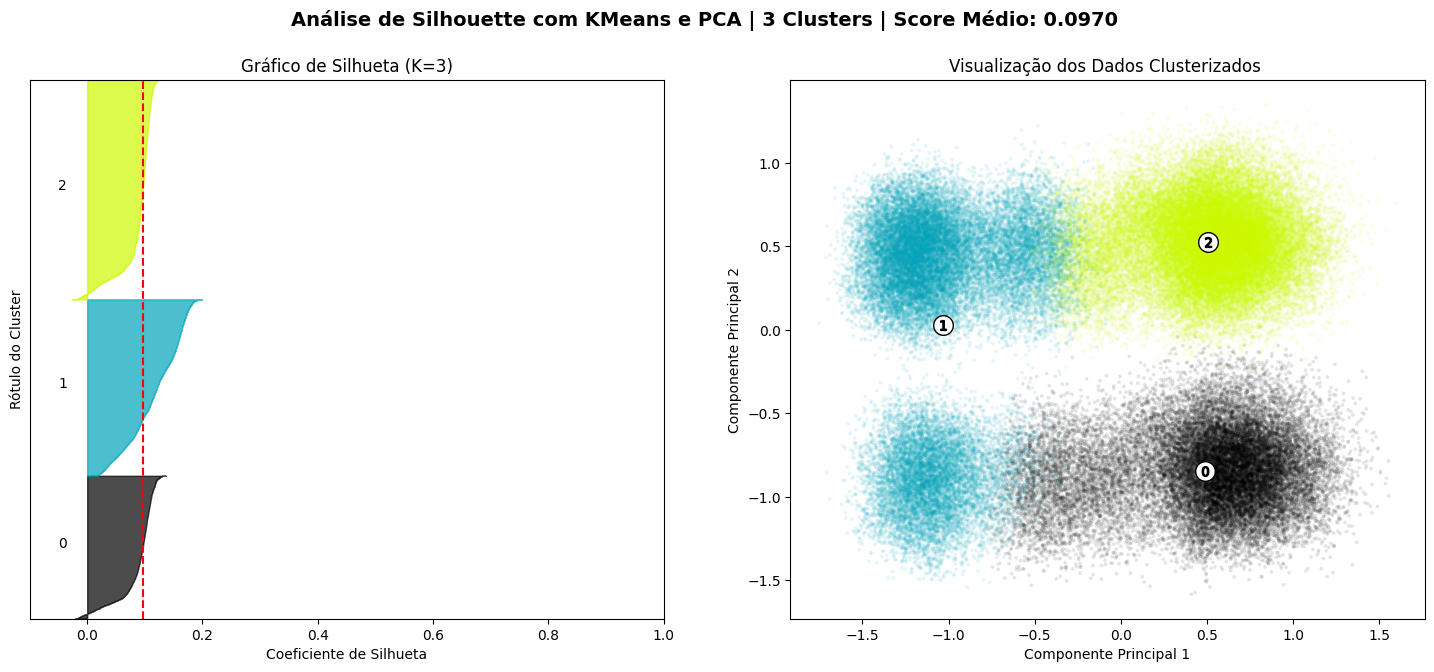

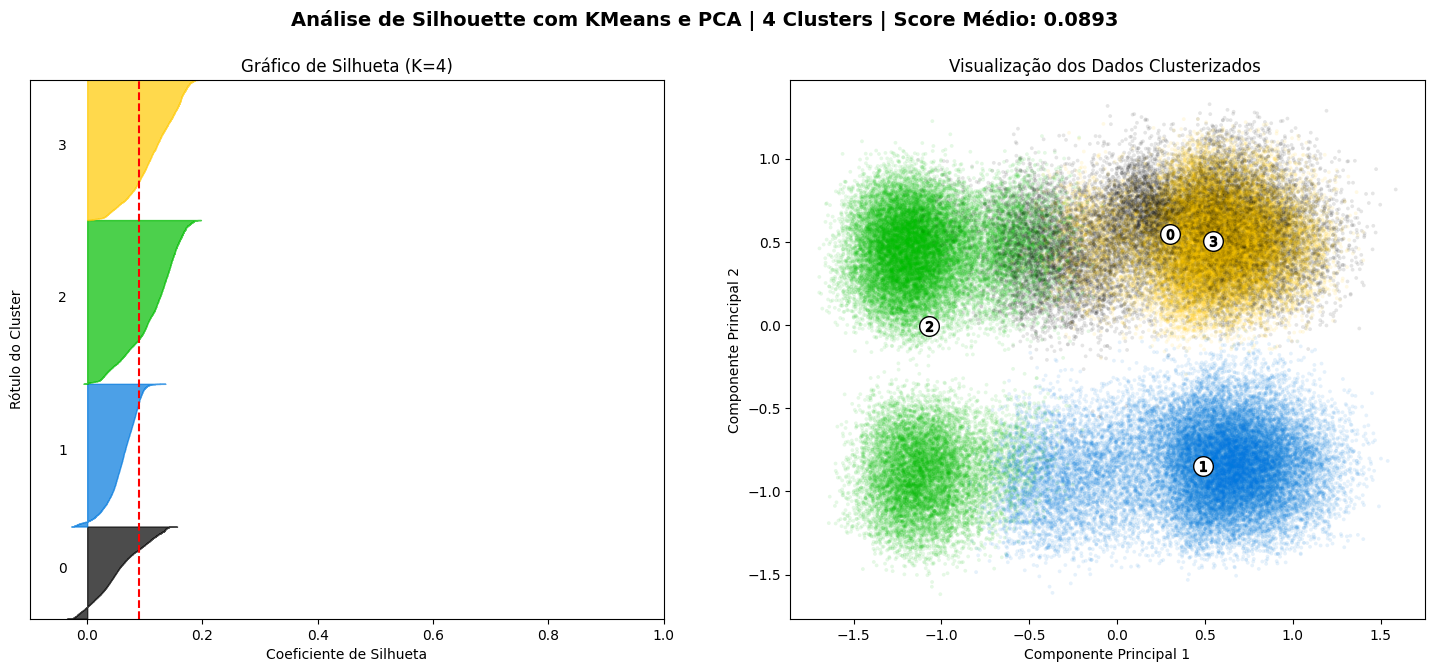

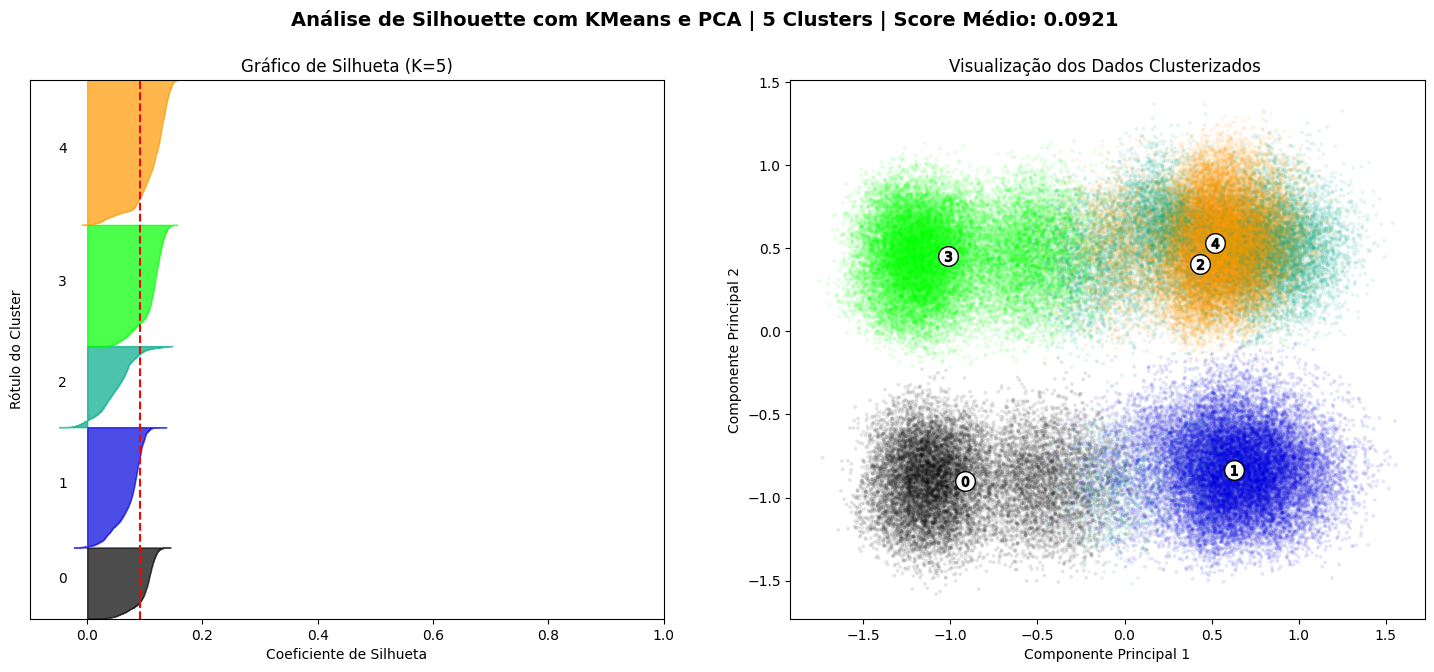

In [ ]:
indexes = np.arange(pca_data.shape[0])

indexes_sample = np.random.choice(indexes, sample_size, replace=False)

pca_sample = pca_data[indexes_sample]

# adicionando jitter para melhor visualização
def add_jitter(arr, noise_level=0.08):
    return arr + np.random.normal(0, noise_level, arr.shape)

for k in n_clusters:
    # clusters salvos no dicionário para a amostra selecionada
    all_clusters = clusters_dict[k]
    sample_clusters = all_clusters[indexes_sample]

    # calcula as métricas novamente com as amostras (consistência)
    avg_score = silhouette_score(pca_sample, sample_clusters)
    sample_values = silhouette_samples(pca_sample, sample_clusters)

    # subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # gráfico de silhueta
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(pca_sample) + (k + 1) * 10])

    y_lower = 10
    for i in range(k):
        ith_cluster_sil_values = sample_values[sample_clusters == i]
        ith_cluster_sil_values.sort()

        size_cluster_i = ith_cluster_sil_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10

    ax1.set_title(f"Gráfico de Silhueta (K={k})")
    ax1.set_xlabel("Coeficiente de Silhueta")
    ax1.set_ylabel("Rótulo do Cluster")
    ax1.axvline(x=avg_score, color="red", linestyle="--")
    ax1.set_yticks([])

    # gráfico de dados clusterizados
    colors = cm.nipy_spectral(sample_clusters.astype(float) / k)

    x_plot = add_jitter(pca_sample[:, 0])
    y_plot = add_jitter(pca_sample[:, 1])

    ax2.scatter(x_plot, y_plot, marker='.', s=30, lw=0, alpha=0.1, c=colors)

    centers = models_dict[k].cluster_centers_
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("Visualização dos Dados Clusterizados ")
    ax2.set_xlabel("Componente Principal 1")
    ax2.set_ylabel("Componente Principal 2")

    plt.suptitle(f"Análise de Silhouette com KMeans e PCA | {k} Clusters | Score Médio: {avg_score:.4f}",
                 fontsize=14, fontweight='bold')
    plt.show()

#### Cálculo do erro do agrupamento para cada **k**

O erro médio é valor do WCSS normalizado pelo número total de amostras no conjunto de dados. Ele indica, em média, quão distante cada registro está do perfil central do seu agrupamento.

In [ ]:
metrics = []

n_rows = train_data.shape[0]

for k, model in models_dict.items():
    # wcss (inércia)
    wcss = model.inertia_
    mean_error = wcss / n_rows

    metrics.append({
        'K': k,
        'WCSS': wcss,
        'Erro Médio': mean_error
    })

metrics_df = pd.DataFrame(metrics).round(3)
metrics_df

,K,WCSS,Erro Médio
0,3,2025667.468,4.518
1,4,1947828.335,4.345
2,5,1877667.184,4.188


## Análise dos clusters

Evidenciando as análises anteriores, escolhi seguir com os clusters de **k=3**

In [ ]:
clustered_df_k_3 = clustered_df.drop(columns=["cluster_k_4", "cluster_k_5"])
clustered_df_k_3.head()

,viol_fisica,viol_sexual,viol_psicologica,viol_autoprovocada,dia_util,fim_semana,primeiro_trim,segundo_trim,terceiro_trim,quarto_trim,vitima_cor_parda,vitima_cor_branca,vitima_cor_preta,vitima_cor_amarela,vitima_cor_indigena,vitima_lgbt,vitima_cis_hetero,autor_sex_masculino,autor_sex_feminino,violencia_repetitiva,violencia_unica,unico_agressor,multiplos_agressores,vitima_crianca,vitima_jovem,vitima_adulto,vitima_meia_idade,vitima_idoso,vitima_senior,local_instit_publica_privada,local_lazer_consumo,local_outros,local_residencia,local_via_publica,regiao_campo_das_vertentes,regiao_central_mineira,regiao_jequitinhonha,regiao_metrop_belo_horizonte,regiao_noroeste_de_minas,regiao_norte_de_minas,regiao_oeste_de_minas,regiao_sul_sudoeste_de_minas,regiao_triangulo_mineiro_alto_paranaiba,regiao_vale_do_mucuri,regiao_vale_do_rio_doce,regiao_zona_da_mata,cluster_k_3
0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,2
1,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2
3,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,2


In [ ]:
# calculando a média de atributo por cluster
df_cluster_means = clustered_df_k_3.groupby("cluster_k_3").mean()
df_cluster_means = df_cluster_means.T
df_cluster_means

cluster_k_3,0,1,2
viol_fisica,0.845420,0.580420,0.773497
viol_sexual,0.149024,0.005249,0.207330
viol_psicologica,0.358155,0.145977,0.400357
viol_autoprovocada,0.057009,0.843690,0.046375
dia_util,0.000000,0.686036,1.000000
fim_semana,1.000000,0.313964,0.000000
primeiro_trim,0.252395,0.239348,0.242163
segundo_trim,0.231377,0.222662,0.237735
terceiro_trim,0.256460,0.266264,0.259174
quarto_trim,0.259768,0.271726,0.260928


#### Heatmap das variáveis por cluster

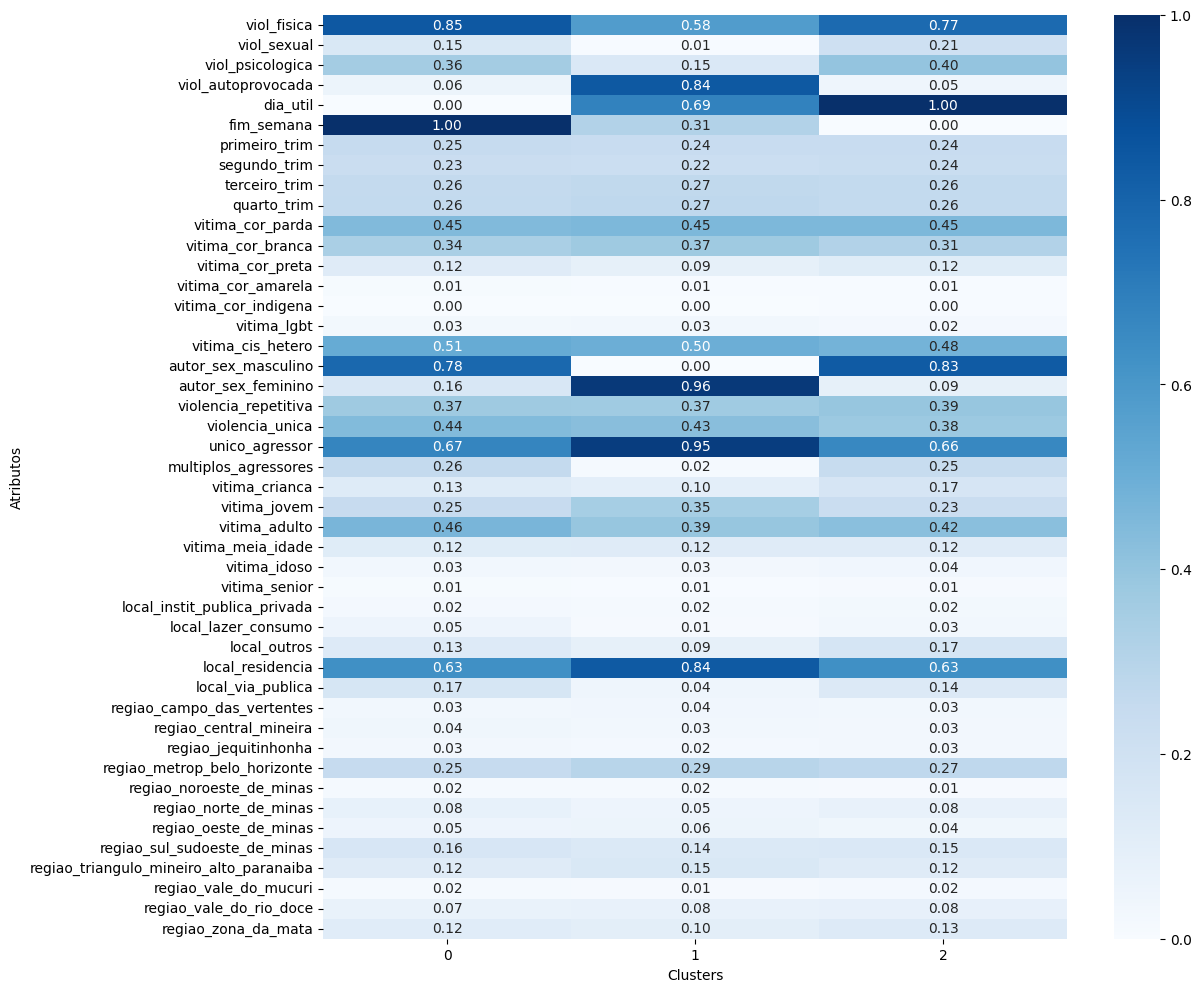

In [ ]:
plt.figure(figsize=(12,12))
ax = sns.heatmap(df_cluster_means,
                 annot=True,
                 cmap='Blues',
                 fmt=".2f",
                 linewidths=0,
                 linecolor='white')
plt.xlabel('Clusters')
plt.ylabel('Atributos')
plt.show()

  ## **Definindo os clusters**

  ### **Cluster 0** - Casos de violência doméstica no fim de semana

  O Cluster 0 rerpesenta majoritariamente a probabilidade de ocorrências de **violência física (82%)** contra contra mulher, seguida por violência psicológica (36%), sexual (15%) e autoprovocada (6%) nos **finais de semana**, onde, nesse grupo, **100%** das ocorrências de violência acontecem de sexta a domingo. O **sexo do autor** da violência é majoritariamente **masculino**, com **78%** de presença na base, seguido pelo feminino em 16%.

  ### **Cluster 1** - Casos de violência autoprovocada pelo sexo feminino em residência

  O Cluster 1 é o perfil mais específico do modelo, concentrando **84% de casos de violência autoprovocada**. Este grupo é quase exclusivamente f**eminino (96% de autoras)** e ocorre majoritariamente no **ambiente doméstico (84%)**. Um marcador social importante deste cluster é a idade: ele apresenta a maior concentração de **vítimas jovens (35%)** entre todos os grupos, sugerindo uma vulnerabilidade específica desta faixa etária ligada à saúde mental. Diferente dos outros, este perfil não é pautado por conflitos externos, o que é reforçado pelo dado de que **95% das ocorrências envolvem um único agressor (a própria vítima)**.

  ### **Cluster 2** - Casos de violência em dias úteis da semana

  O Cluster 2 foca na **violência física (77%)** que ocorre estritamente de segunda a quinta-feira **(100% em dias úteis)**. Embora o ambiente doméstico ainda seja predominante (63%), este grupo se diferencia por ter a maior abertura para o espaço público e coletivo: possui as maiores taxas de agressões em **vias públicas (14%) e locais categorizados como "outros" (17%)**. Além disso, apresenta a maior incidência de **múltiplos agressores (25%)** e **autores do sexo masculino (83%)**, indicando um perfil de violência interpessoal que, apesar de ainda invadir o lar, possui uma dinâmica de conflito mais urbana e externa do que os demais clusters